In [1]:
import pandas as pd
import matplotlib as mpl
import sqlite3

%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,7)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
conn = sqlite3.connect('casino.db')
#conn.close()

# Games stats

In [3]:
q = """
select g.game
    , fb.id_game
    , g.rtp as RTP
    , g.volatility
    , sum(number_of_bets) as total_bets
    , count(distinct userid) as users
    , sum(bet_euro) as total_bet_euro
    , sum(bet_euro) - sum(win_euro) as total_profit
    , count(distinct organization) as organizations
    , cast(sum(bet_euro) - sum(win_euro) as real) / count(distinct userid) as profit_per_user
    , cast(sum(number_of_bets) as real) / count(distinct userid) as bets_per_user
    , cast(count(*) as real) / count(distinct userid) as sessions_per_user
    , min(date(date)) as first_bet_date
    , max(date(date)) as last_bet_date
    , julianday(date('now')) - julianday(min(date(date))) as days_on_market
from FACT_BETS as fb
join GAMES as g on fb.id_game = g.id_game
group by fb.id_game
order by total_bets desc;
"""
df = pd.read_sql(q, conn)
df['%_of_all_bet_euro'] = df['total_bet_euro']*100 / sum(df['total_bet_euro'])
df['%_of_all_bets'] = df['total_bets']*100 / sum(df['total_bets'])
df.head(10)

,game,id_game,RTP,volatility,total_bets,users,total_bet_euro,total_profit,organizations,profit_per_user,bets_per_user,sessions_per_user,first_bet_date,last_bet_date,days_on_market,%_of_all_bet_euro,%_of_all_bets
0,game_41,7458,0.956,54,621582,1045,1661053.605,148042.890,82,141.668,594.815,4.471,2016-11-21,2017-11-30,436.000,18.148,17.496
1,game_16,7444,0.955,36,446409,767,2591462.406,94149.709,80,122.751,582.020,4.287,2015-09-23,2017-11-30,861.000,28.313,12.565
2,game_5,7435,0.955,160,336163,395,644377.418,8079.340,77,20.454,851.046,4.382,2015-01-01,2017-11-30,1126.000,7.040,9.462
3,game_42,7443,0.958,48,253649,901,611274.438,50356.100,92,55.889,281.519,3.107,2015-08-20,2017-11-29,895.000,6.678,7.139
4,game_15,7449,0.959,68,208681,820,494377.546,12163.703,87,14.834,254.489,3.298,2016-02-17,2017-11-30,714.000,5.401,5.874
5,game_18,7439,0.938,46,138945,390,351672.253,38809.335,27,99.511,356.269,3.800,2015-04-22,2017-11-30,1015.000,3.842,3.911
6,game_40,7468,0.957,77,119592,426,196096.477,-2658.177,65,-6.240,280.732,3.129,2017-08-17,2017-11-30,167.000,2.142,3.366
7,game_22,7452,0.955,43,93788,552,215343.713,20449.847,68,37.047,169.906,2.712,2016-05-17,2017-11-30,624.000,2.353,2.640
8,game_17,7447,0.956,35,93511,353,81581.338,4996.313,60,14.154,264.904,3.025,2016-01-14,2017-11-28,748.000,0.891,2.632
9,game_25,7446,0.957,60,93091,579,118745.353,5391.417,76,9.312,160.779,2.354,2015-11-18,2017-11-30,805.000,1.297,2.620


**Prediction idea:** Predict game performance (ex. popularity) in longer period (ex 6 months) based on shorter period (ex. 1 month). It can be done by comparing it's starting period to older games. KNN algorithm may be good here.

*all games are available today, since launched (last_bet_date column has similar values for all games) 

In [80]:
18.148 + 28.313

46.461

game_41 and game_16 generate 46.46% of volume (%_of_all_bet_euro) and has 1045 users (most of all).

In [81]:
17.496 + 12.565

30.061

30% of all bets is placed in those games

People come back to game game_41 most often (4.471 sessions per user on average)

### Why game game_40 generates minus profit?

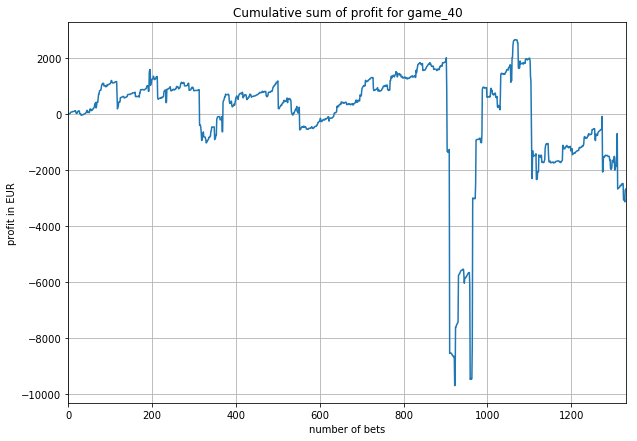

In [108]:
q = """
select 
    bet_euro - win_euro as profit
from FACT_BETS as fb
join GAMES as g on fb.id_game = g.id_game
where g.game = 'game_40'
order by date(date);
"""
cumsum_bets = pd.read_sql(q, conn)['profit'].cumsum()
plt = cumsum_bets.plot(y='profit', grid=True, title ='Cumulative sum of profit for game_40')
plt.set_xlabel("number of bets")
plt.set_ylabel("profit in EUR")

In [114]:
q = """
select 
    bet_euro - win_euro as profit,
    number_of_bets,
    userid as user,
    datetime(slice_from) as date_time   
from FACT_BETS as fb
join GAMES as g on fb.id_game = g.id_game
where g.game = 'game_40'
order by profit asc;
"""
df = pd.read_sql(q, conn)
df.head()

,profit,number_of_bets,user,date_time
0,-7280.759,112,1603052314408300303,2017-10-19 14:00:00
1,-3330.725,310,1603052314408300303,2017-10-25 14:00:00
2,-2223.453,142,1603052314408300303,2017-10-18 19:00:00
3,-1984.700,282,1710231759410400180,2017-11-27 13:00:00
4,-1979.160,412,1710231759410400180,2017-11-29 12:00:00


# Players

In [67]:
q = """
select userid
    , sum(number_of_bets) as total_bets
    , sum(bet_euro) as total_bet_euro
    , sum(bet_euro) - sum(win_euro) as profit_from_user_euro
    , cast(sum(number_of_bets) as real) / count(distinct userid) as bets_per_user
    , cast(count(*) as real) / count(distinct userid) as sessions_per_user
    , julianday(date('now')) - julianday(min(date(date))) as since_first_game
from FACT_BETS
group by userid
--order by total_bets desc;
order by total_bet_euro desc;
"""
df['%_of_all_bet_euro'] = df['total_bet_euro']*100 / sum(df['total_bet_euro'])
df['%_of_all_bets'] = df['total_bets']*100 / sum(df['total_bets'])
df.head(10)

,userid,total_bets,total_bet_euro,profit_from_user_euro,bets_per_user,sessions_per_user,since_first_game,%_of_all_bet_euro,%_of_all_bets
0,1511140936547100173,48819,1558859.250,37712.831,48819.000,223.000,808.000,17.031,1.374
1,1603052314408300303,32407,745402.586,67211.661,32407.000,203.000,696.000,8.144,0.912
2,1601262139055800364,16952,395275.000,22857.890,16952.000,88.000,735.000,4.319,0.477
3,1605231707026700241,28763,347765.550,8068.402,28763.000,107.000,617.000,3.799,0.810
4,1601112113152400306,13122,302010.150,52218.236,13122.000,65.000,434.000,3.300,0.369
5,1606032357330000243,17206,222743.684,11634.346,17206.000,88.000,606.000,2.434,0.484
6,1507032106447800173,45914,216940.950,8608.360,45914.000,188.000,942.000,2.370,1.292
7,1708020409040200177,15383,208695.200,334.968,15383.000,164.000,181.000,2.280,0.433
8,1512151343298900215,6673,172147.364,18562.185,6673.000,22.000,777.000,1.881,0.188
9,1706061843120800196,9260,166732.000,12766.356,9260.000,33.000,238.000,1.822,0.261


One player betted 17% of all betted money and 1.4% of number of all bets.

In [75]:
print("20 players ({:.2f}%) betting most money generate {:.2f}% of volume (%_of_all_bet_euro).".format(
    20*100 / len(df),
    df['%_of_all_bet_euro'].head(20).sum()))

20 players (0.42%) betting most money generate 59.22% of volume (%_of_all_bet_euro).
